# Um Simples Autoencoder

Vamos começar criando um autoencoder simples para compactar a base de dados MNIST. Com os autoencoders, passamos os dados de entrada através de um codificador que faz uma representação compactada da entrada. Então, essa representação é passada através de um decodificador para reconstruir os dados de entrada. Geralmente, o codificador e o decodificador serão construídos com redes neurais e depois treinados sobre o conjunto de testes.

Aqui, vamos apenas utilizar conjuntos de treinamento e de teste, por simplicidade, mas fica como um exercício para o leitor a implementação do mesmo processo adicionando conjunto de validação.

<img src='notebook_ims/autoencoder_1.png' />

### Representação Comprimida

Uma representação comprimida pode ser excelente para salvar e compartilhar quaisquer tipos de dados de uma maneira mais eficiente do que armazenar dados brutos. Na prática, a representação comprimida geralmente contém informações importantes sobre uma imagem de entrada e podemos usá-la para remover ruídos de imagens ou outros tipos de reconstrução e transformação!

<img src='notebook_ims/denoising.png' width=60%/>

Neste notebook, criaremos uma arquitetura simples para o codificador e o decodificador.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...
Done!


In [2]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 1
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualização de Dados

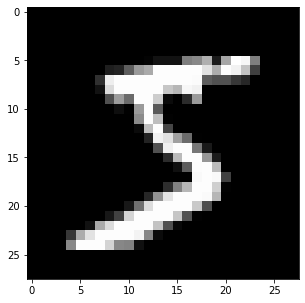

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Autoencoder linear

Treinaremos um autoencoder com essas imagens, iremos linearizar as imagens em vetores de tamanho 784 (pois cada imagem mede 28x28 pixels). As imagens deste conjunto de dados já estão normalizadas, de modo que os valores estão entre 0 e 1. Vamos começar criando um autoencoder simples. O codificador e o decodificador devem ser feitos de **uma camada linear**. As unidades que conectam o codificador e o decodificador serão a _representação comprimida_.

Como as imagens estão normalizadas entre 0 e 1, precisamos usar uma **função de ativação sigmóide na camada de saída** para obter valores que correspondam a esse intervalo de valores da entrada.

<img src='notebook_ims/simple_autoencoder.png' width=50% />

#### Observações
> As imagens de entrada serão achatadas em vetores de 784 elementos de comprimento. Os targets são os mesmos que as entradas (por isso dizemos que essa aplicação é não supervisionada).
> O codificador e o decodificador serão constituídos por duas camadas lineares, cada uma.
> As dimensões devem mudar da seguinte forma: 784 entradas > **encoding_dim** > 784 saídas.
> Todas as camadas terão ativações ReLu, exceto a camada de saída final, que possui uma função de ativação sigmóide.

**A representação comprimida deve ser um vetor com dimensão `encoding_dim = 32`.**

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.fc2(x))
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


---
## Treinamento

Vamos treinar a rede. Não estou muito interessado em validação aqui.

Não estamos preocupados com labels neste caso, apenas imagens, que podemos obter do `train_loader`. Como estamos comparando valores de pixel em imagens de entrada e saída, será melhor usar uma loss destinada a uma tarefa de regressão. Regressão tem a ver com comparar _quantidades_ em vez de valores probabilísticos. Portanto, neste caso, usarei o `MSELoss` e comparar imagens de saída e imagens de entrada da seguinte maneira:
```
loss = criterion(outputs, images)
```

Este é um treinamento bastante direto com o PyTorch. Achatamos nossas imagens, passamos para o autoencoder e guardamos a loss de treinamento à medida que avançamos.

In [5]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.670684
Epoch: 2 	Training Loss: 0.365664
Epoch: 3 	Training Loss: 0.321818
Epoch: 4 	Training Loss: 0.312180
Epoch: 5 	Training Loss: 0.308412
Epoch: 6 	Training Loss: 0.306200
Epoch: 7 	Training Loss: 0.304455
Epoch: 8 	Training Loss: 0.303306
Epoch: 9 	Training Loss: 0.302409
Epoch: 10 	Training Loss: 0.301661
Epoch: 11 	Training Loss: 0.300977
Epoch: 12 	Training Loss: 0.300343
Epoch: 13 	Training Loss: 0.299677
Epoch: 14 	Training Loss: 0.299115
Epoch: 15 	Training Loss: 0.298591
Epoch: 16 	Training Loss: 0.298096
Epoch: 17 	Training Loss: 0.297614
Epoch: 18 	Training Loss: 0.297157
Epoch: 19 	Training Loss: 0.296711
Epoch: 20 	Training Loss: 0.296275


## Checando os resultados

Abaixo, plotamos algumas das imagens de teste junto com suas reconstruções. Na maioria das vezes, elas parecem muito boas, exceto por algumas manchas.

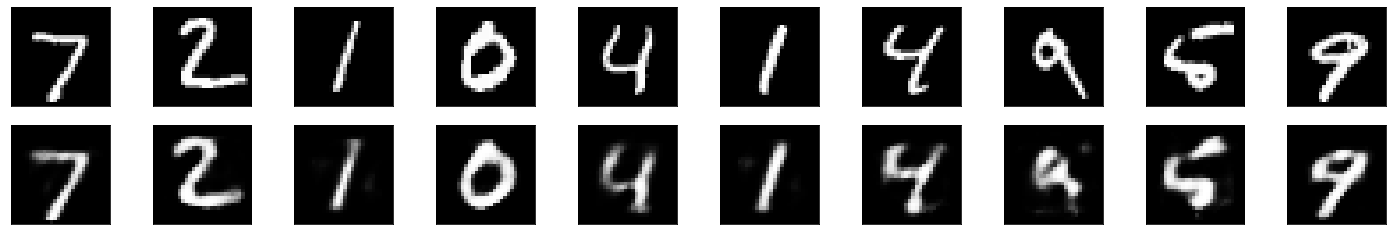

In [7]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Neste exemplo, utilizamos redes neurais simples para processar essas imagens, mas conseguimos melhores resultados utilizando CNNs. Veremos como fazer isso já já.